In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets,neighbors, decomposition
import time
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import matplotlib as mpl

In [2]:
EBT_counts = sc.read_h5ad('../1_EB/EBT_counts_sqrt.h5ad')
EBT_counts

AnnData object with n_obs × n_vars = 16821 × 17845
    obs: 'cell_type'

In [3]:
cell_stage = EBT_counts.obs['cell_type'].values.reshape(-1)

In [4]:
eb_dpt_pseudotime = pd.read_csv("../1_EB/eb.dpt_pseudotime.csv",index_col=0).values.reshape(-1)
eb_palantir_time = pd.read_csv("../1_EB/eb.palantir_pseudotime.csv",index_col=0).values.reshape(-1)
eb_monocle_time = pd.read_csv("../1_EB/eb.monocle_pseudotime.csv",index_col=0).values.reshape(-1)
eb_dtne_time = pd.read_csv("../1_EB/eb.dtne_pseudotime.csv",index_col=0).values.reshape(-1)

In [5]:
df = pd.DataFrame({"DTNE":eb_dtne_time,"DPT":eb_dpt_pseudotime,"Palantir":eb_palantir_time,"Monocle":eb_monocle_time,"cell_stage":cell_stage})

In [6]:
def bh(pvalues: np.array) -> np.array:
    """
    Compute the Benjamini-Hochberg FDR correction.

    Parameters
    ----------
    pvalues : np.array
        array of p-values to correct

    Returns
    -------
    np.array
        np.array of corrected p-values
    """
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n / rank) * pvalue)
    for i in range(0, int(n) - 1):
        if new_values[i] < new_values[i + 1]:
            new_values[i + 1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

from typing import List
def chatterjee_corr(X: np.ndarray, genes: List[str], pseudotime: np.ndarray) -> pd.DataFrame:
    
    # compute chatterjee correlation
    stat = 1 - np.sum(np.abs(np.diff(np.argsort(X[np.argsort(pseudotime), :], axis=0), axis=0)), axis=0 ) * 3 / (X.shape[0] ** 2 - 1)
    stat = np.array(stat).flatten()
    
    pval = 1 - stats.norm.cdf(stat, loc=0, scale=np.sqrt(2 / 5 / X.shape[0]))
    
    # put results into data frame cor_res
    cor_res = pd.DataFrame({"cor_stat": stat, "pval": pval})
    cor_res.index = genes
    
    # compute adjusted pval using BH method
    cor_res["adj_pval"] = bh(cor_res["pval"].to_numpy())
    
    # sort genes based on adjusted pval
    cor_res = cor_res.sort_values(by="adj_pval")
    # cor_res = cor_res.sort_values(by="cor_stat")
    
    return cor_res

def bin_expression(X: np.ndarray, bin_num: int, genes: List[str], pseudotime: np.ndarray) -> pd.DataFrame:
    
    bins = np.linspace(0, 1, bin_num + 1)
    gene_summary = pd.DataFrame(columns=bins[:-1], index=genes)
    
    # calculate average gene expression in each bin
    for i in range(bin_num):
        time = bins[i]
        select = np.array(bins[i] <= pseudotime) & np.array(pseudotime < bins[i + 1])
        gene_summary.loc[:, time] = np.mean(X[select, :], axis=0)
    
    return gene_summary  

In [7]:
genes = EBT_counts.var_names
X = EBT_counts.X

In [8]:
df = pd.DataFrame(X,columns=genes)

In [9]:
selected_genes = ['A1BG (ENSG00000121410)','LECT1 (ENSG00000136110)','PITX2 (ENSG00000164093)','PLD3 (ENSG00000105223)','PLAGL1 (ENSG00000118495)','PLTP (ENSG00000100979)',
                  'PITX2 (ENSG00000164093)','PMAIP1 (ENSG00000141682)','POU5F1 (ENSG00000204531)', 'RHOC (ENSG00000155366)','TDGF1 (ENSG00000241186)',]
selected_df = df.loc[:,selected_genes]
gene_summary = bin_expression(selected_df.values,100,selected_genes,eb_dtne_time)
df2 = gene_summary.apply(pd.to_numeric, errors='coerce')

<Axes: >

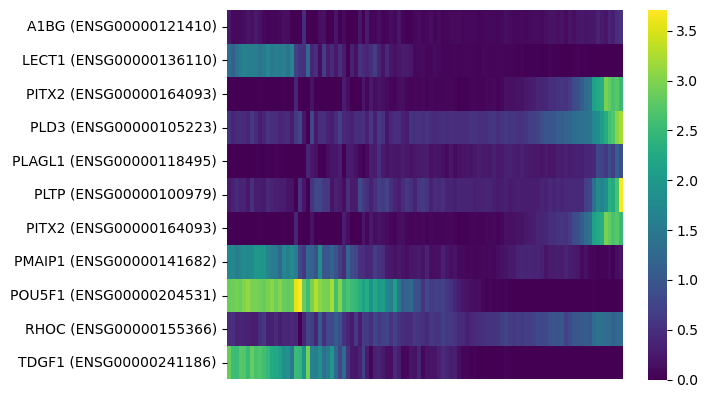

In [10]:
sns.heatmap(df2, annot=False,xticklabels=False,cmap='viridis')

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [12]:
correlation = ['Kendall’s tau','Spearman']
pseudotime_corr = {
    'DPT':(0.656, 0.801),
    'Palantir':(0.550, 0.686),
    'Monocle3':(0.541, 0.682),
    'DTNE':(0.695, 0.838)
    }

In [13]:
import matplotlib.gridspec as gridspec

In [14]:
? im.xaxis.set_label_coords

Object ` im.xaxis.set_label_coords` not found.


C:\Users\Jon\AppData\Local\Temp\ipykernel_18028\519215769.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0, 0.33, 0.9, 0.65])
C:\Users\Jon\AppData\Local\Temp\ipykernel_18028\519215769.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs3.tight_layout(fig, rect=[0.09, 0, 0.9, 0.33])


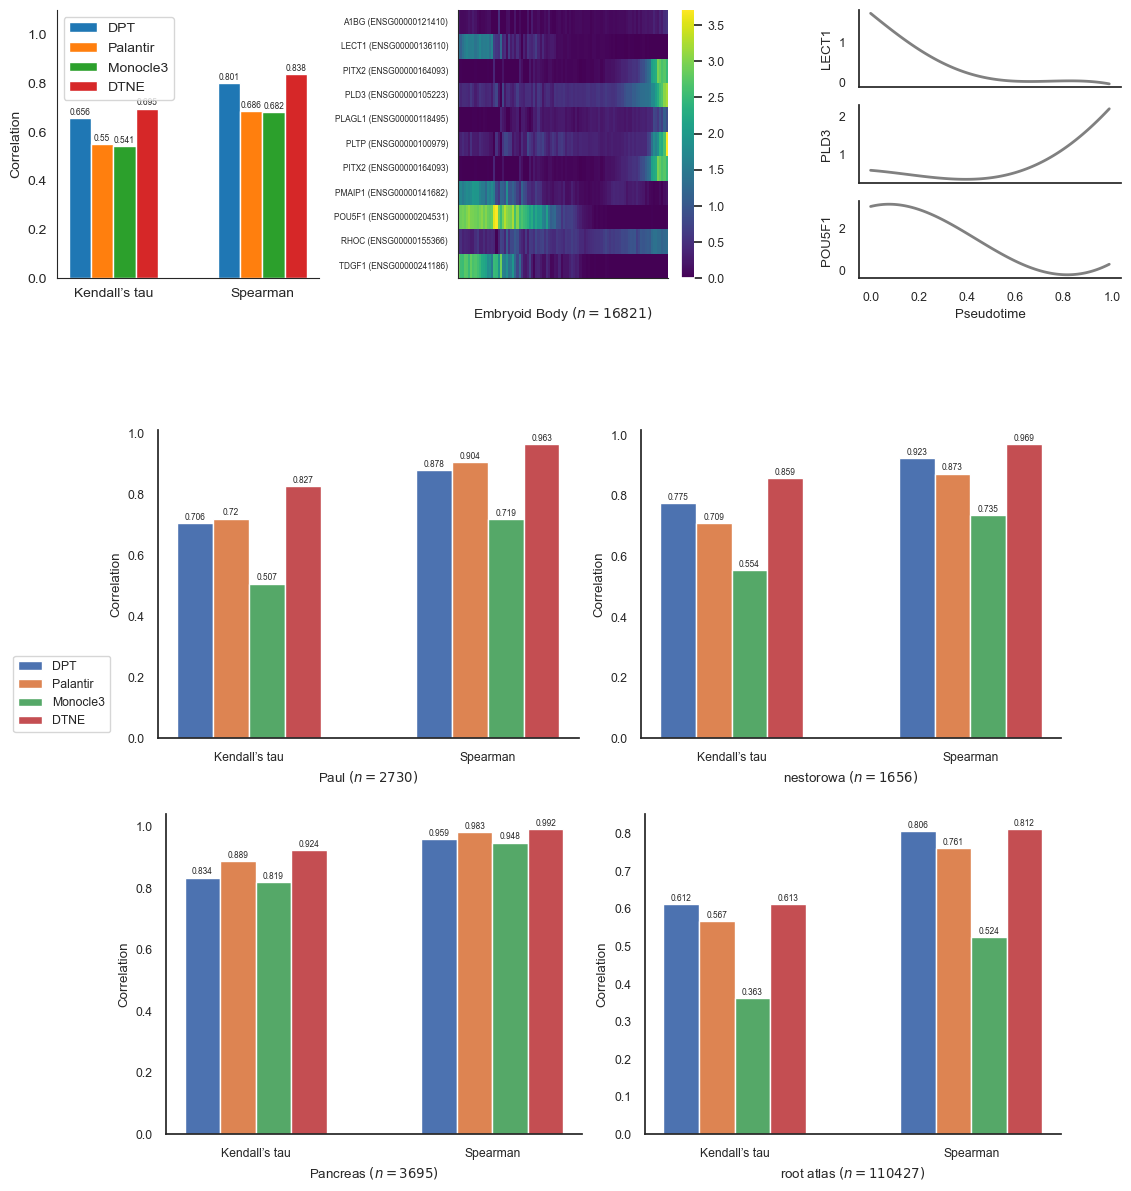

In [15]:
fig = plt.figure(figsize=(12, 12))

gs1 = gridspec.GridSpec(3, 3)

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

sns.set_style(style='white')

ax0 = fig.add_subplot(gs1[:,0])
for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax0.bar(x + offset, corr, width, label=name)
    ax0.bar_label(rects, padding=1,fontsize=6)
    multiplier += 1

ax0.set_ylabel('Correlation')
ax0.set_xticks(x + 1.5*width, correlation)
ax0.legend(loc='upper left', ncols=1)
ax0.set_ylim(0, 1.1)

sns.despine(top=True,right=True,left=False,bottom=False,)

ax1 = fig.add_subplot(gs1[:,1])
sns.set(font_scale=0.8)
im = sns.heatmap(df2, annot=False,xticklabels=False,cmap='viridis')
_, labels = plt.yticks()
im.set_yticklabels(labels, size = 6, rotation=00)

im.set_xlabel("Embryoid Body $(n=16821)$",fontsize = 10)
im.xaxis.set_label_coords(0.5, -0.1)
im.figure.tight_layout()

sns.set_style(style='white')
ax4 = fig.add_subplot(gs1[0,2])
bt = np.array(np.arange(100)/100).reshape(-1,1)
bv = df2.loc['LECT1 (ENSG00000136110)'].values
gp = GaussianProcessRegressor(alpha = 0.0001).fit(bt,bv).predict(bt)
# plt.scatter(np.arange(100)/100,df2.loc['PLD3 (ENSG00000105223)'].values,s=10)
im3 = ax4.plot(bt, gp, linewidth=2, linestyle='-',c='grey')
ax4.set(xticklabels=[],ylabel='LECT1')
sns.despine(top=True,right=True,left=False,bottom=False,)


ax3 = fig.add_subplot(gs1[1,2])
bt = np.array(np.arange(100)/100).reshape(-1,1)
bv = df2.loc['PLD3 (ENSG00000105223)'].values
gp = GaussianProcessRegressor(alpha = 0.01).fit(bt,bv).predict(bt)
# plt.scatter(np.arange(100)/100,df2.loc['PLD3 (ENSG00000105223)'].values,s=10)
im2 = ax3.plot(bt, gp, linewidth=2, linestyle='-',c='grey')
ax3.set(xticklabels=[], ylabel='PLD3')
ax3.figure.tight_layout()
sns.despine(top=True,right=True,left=False,bottom=False,)

ax4 = fig.add_subplot(gs1[2,2])
bt = np.array(np.arange(100)/100).reshape(-1,1)
bv = df2.loc['POU5F1 (ENSG00000204531)'].values
gp = GaussianProcessRegressor(alpha = 0.001).fit(bt,bv).predict(bt)
# plt.scatter(np.arange(100)/100,df2.loc['PLD3 (ENSG00000105223)'].values,s=10)
im3 = ax4.plot(bt, gp, linewidth=2, linestyle='-',c='grey')
ax4.set(xlabel='Pseudotime', ylabel='POU5F1')
sns.despine(top=True,right=True,left=False,bottom=False,)

gs1.tight_layout(fig, rect=[0, 0.65, 0.95, 1])

############################################
gs2 = gridspec.GridSpec(1, 2)

ax02 = fig.add_subplot(gs2[0])

pseudotime_corr = {
    'DPT':(0.706, 0.878),
    'Palantir':(0.720, 0.904),
    'Monocle3':(0.507, 0.719),
    'DTNE':(0.827, 0.963)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax02.bar(x + offset, corr, width, label=name)
    ax02.bar_label(rects, padding=1,fontsize=6)
    multiplier += 1

ax02.set_xlabel('Paul $(n=2730)$')
ax02.set_ylabel('Correlation')
ax02.set_xticks(x + 1.5*width, correlation)
# ax02.set_ylim(0, 1)
# ax02.legend(loc='upper left', ncols=1)
ax02.legend(loc=4, bbox_to_anchor=(-0.1, 0))

sns.despine(top=True,right=True,left=False,bottom=False,)

#####
ax03 = fig.add_subplot(gs2[1])

pseudotime_corr = {
    'DPT':(0.775, 0.923),
    'Palantir':(0.709, 0.873),
    'Monocle3':(0.554, 0.735),
    'DTNE':(0.859, 0.969)
    }
x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax03.bar(x + offset, corr, width, label=name)
    ax03.bar_label(rects, padding=1,fontsize=6)
    multiplier += 1

ax03.set_xlabel('nestorowa $(n=1656)$')
ax03.set_ylabel('Correlation')
ax03.set_xticks(x + 1.5*width, correlation)
# ax03.set_ylim(0, 1)
sns.despine(top=True,right=True,left=False,bottom=False,)



gs2.tight_layout(fig, rect=[0, 0.33, 0.9, 0.65])

#################################################
gs3 = gridspec.GridSpec(1, 2)
ax04 = fig.add_subplot(gs3[0])

pseudotime_corr = {
    'DPT':(0.834, 0.959),
    'Palantir':(0.889, 0.983),
    'Monocle3':(0.819, 0.948),
    'DTNE':(0.924, 0.992)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax04.bar(x + offset, corr, width, label=name)
    ax04.bar_label(rects, padding=1,fontsize=6)
    multiplier += 1

ax04.set_xlabel('Pancreas $(n=3695)$')
ax04.set_ylabel('Correlation')
ax04.set_xticks(x + 1.5*width, correlation)
# ax04.set_ylim(0, 1)
sns.despine(top=True,right=True,left=False,bottom=False,)


ax05 = fig.add_subplot(gs3[1])
pseudotime_corr = {
    'DPT':(0.612, 0.806),
    'Palantir':(0.567, 0.761),
    'Monocle3':(0.363, 0.524),
    'DTNE':(0.613, 0.812)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax05.bar(x + offset, corr, width, label=name)
    ax05.bar_label(rects, padding=1,fontsize=6)
    multiplier += 1

ax05.set_xlabel('root atlas $(n=110427)$')
ax05.set_ylabel('Correlation')
ax05.set_xticks(x + 1.5*width, correlation)
# ax05.legend(loc='upper left', ncols=1)
# ax05.set_ylim(0, 1)

sns.despine(top=True,right=True,left=False,bottom=False,)

gs3.tight_layout(fig, rect=[0.09, 0, 0.9, 0.33])

plt.savefig('./sc_tr_plot.png', format='png', dpi=1000)
plt.savefig('./sc_tr_plot.pdf', format='pdf', dpi=1000)